In [1]:
# ---- Reproducibility
import random
import torch

seed = 1234
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [2]:


# ---- Parameters
n, p = 50, 40
noise_std = 0.1

# (Optional) choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Data generation (PyTorch)
# Use float64 to mirror NumPy defaults
u = torch.rand(n, dtype=torch.float64, device=device)          # length n
v = torch.rand(p, dtype=torch.float64, device=device)          # length p

# Rank-1 matrix via outer product
rank_1_matrix = torch.outer(u, v)                              # (n, p)

# Homoscedastic Gaussian noise
noise = noise_std * torch.randn(n, p, dtype=torch.float64, device=device)

noisy_matrix = rank_1_matrix + noise

# ---- Print (move to CPU for readability if needed)
print("Rank-1 Matrix (Outer Product):")
print(rank_1_matrix.cpu().numpy())

print("\nNoisy Matrix (with Homoscedastic Noise):")
print(noisy_matrix.cpu().numpy())


Rank-1 Matrix (Outer Product):
[[0.0369924  0.12349849 0.01266485 ... 0.20919041 0.20178125 0.15269329]
 [0.01256629 0.04195233 0.00430224 ... 0.0710618  0.06854491 0.05186978]
 [0.07442166 0.24845541 0.02547927 ... 0.42085123 0.40594542 0.3071898 ]
 ...
 [0.13003676 0.43412546 0.04451985 ... 0.73535219 0.70930731 0.53675188]
 [0.02568535 0.08575008 0.00879373 ... 0.14524951 0.14010503 0.10602124]
 [0.01213768 0.04052142 0.0041555  ... 0.06863803 0.06620699 0.05010061]]

Noisy Matrix (with Homoscedastic Noise):
[[ 0.14788041  0.16955928  0.1824038  ...  0.06284919  0.26615598
   0.04153663]
 [-0.07975735  0.07738678 -0.06536086 ...  0.08710195  0.01799688
   0.10035783]
 [ 0.15693369  0.13496091 -0.12057474 ...  0.40187727  0.53974668
   0.3314774 ]
 ...
 [ 0.16086152  0.64130937  0.12866035 ...  0.67670073  0.59595961
   0.57849158]
 [-0.06675871 -0.03323521 -0.03429034 ...  0.1487228   0.2078188
   0.18898802]
 [-0.14480705  0.07884231  0.03359961 ... -0.16932926  0.1779711
   0.1486

In [3]:
import sys
import os
import matplotlib.pyplot as plt
from cebmf_torch import cEBMF

In [4]:
mycebmf=  cEBMF(data= noisy_matrix,
                prior_L="point_exp",
                  prior_F="point_exp") 

In [5]:
mycebmf.initialize()
print(mycebmf.L[:,1])
print(mycebmf.F[:,1])

tensor([ 0.0080, -0.1905,  0.2605, -0.2120,  0.2116,  0.1896, -0.2458, -0.2640,
         0.1057,  0.1225,  0.0676,  0.0620, -0.0016,  0.1750,  0.1087, -0.0761,
         0.1078, -0.4832,  0.0641,  0.1960, -0.2287, -0.0704, -0.2441,  0.0377,
        -0.2611, -0.1291,  0.3901, -0.0387, -0.1331, -0.2875, -0.2095,  0.1439,
        -0.0307, -0.0648,  0.0598, -0.0430,  0.1896,  0.1109,  0.0643, -0.0023,
        -0.0328, -0.2137,  0.0720,  0.0039, -0.1591, -0.2714, -0.0136,  0.1367,
         0.0542,  0.2452])
tensor([ 0.0610,  0.0381, -0.0373,  0.1844, -0.0388, -0.1764,  0.0488, -0.3281,
        -0.0793,  0.0009,  0.2299,  0.1970,  0.0735, -0.2066,  0.0725, -0.2878,
        -0.0727,  0.3067, -0.2505,  0.0539,  0.1928,  0.0201, -0.0158,  0.1157,
         0.1509,  0.0815,  0.0377,  0.1380,  0.1188, -0.1703, -0.0225, -0.0766,
        -0.2759,  0.2154,  0.2396, -0.1764, -0.0045, -0.1609,  0.1603,  0.0669])


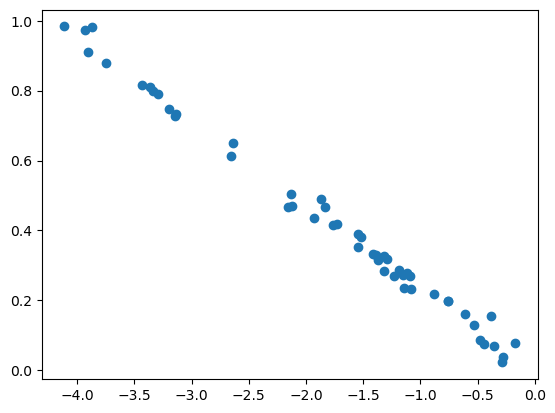

In [6]:
plt.scatter( mycebmf.L[:,0],u)

In [7]:
mycebmf.initialize () 
tau_map=None
eps=1e-12

In [8]:
for k in range (mycebmf.K):
# ---------- Update L[:, k] ----------
        Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
        fk  = mycebmf.F[:, k]                                # (P,)
        fk2 = mycebmf.F2[:, k]                               # (P,)

        if tau_map is None:
            denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
            num_l   = (Rk @ fk)                                                   # (N,)
            se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))
        else:
            denom_l = (tau_map * (fk2.view(1, -1) * mycebmf.mask)).sum(dim=1).clamp_min(eps)  # (N,)
            num_l   = (tau_map * Rk) @ fk                                                 # (N,)
            se_l    = torch.sqrt(1.0 / denom_l)

        lhat = num_l / denom_l
       # print(denom_l)
        resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
        )
        mycebmf.model_state_L[k] = resL.model_param
        mycebmf.L[:, k]  = resL.post_mean
        mycebmf.L2[:, k] = resL.post_mean2
        mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)

    # ---------- Update F[:, k] ----------
        Rk = mycebmf._partial_residual_masked(k)            # recompute with updated L
        lk  = mycebmf.L[:, k]                               # (N,)
        lk2 = mycebmf.L2[:, k]                              # (N,)

        if tau_map is None:
            denom_f = (lk2.view(-1, 1) * mycebmf.mask).sum(dim=0).clamp_min(eps)      # (P,)
            num_f   = (Rk.T @ lk)                                                  # (P,)
            se_f    = torch.sqrt(1.0 / (mycebmf.tau * denom_f))
        else:
            denom_f = (tau_map * (lk2.view(-1, 1) * mycebmf.mask)).sum(dim=0).clamp_min(eps)  # (P,)
            num_f   = (tau_map * Rk).T @ lk                                                # (P,)
            se_f    = torch.sqrt(1.0 / denom_f)

        fhat = num_f / denom_f
        print(denom_f[1])
        resF = mycebmf.prior_F_fn(
            X=getattr(mycebmf, "X_f", None),
            betahat=fhat,
            sebetahat=se_f,
            model_param=mycebmf.model_state_F[k]
        )
        mycebmf.model_state_F[k] = resF.model_param
        mycebmf.F[:, k]  = resF.post_mean
        mycebmf.F2[:, k] = resF.post_mean2
        mycebmf.kl_f[k]  = torch.as_tensor(resF.loss, device=mycebmf.device)
 
print(mycebmf.F)

tensor(0.0050)
tensor(0.3803)
tensor(0.4633)
tensor(0.4120)
tensor(0.3384)
tensor([[0.0099, 0.2902, 0.1756, 0.5005, 0.0739],
        [0.0099, 1.1556, 1.1131, 0.8634, 0.5329],
        [0.0099, 0.0739, 0.1353, 0.1046, 0.0567],
        [0.0099, 1.9673, 1.2419, 0.9136, 0.9686],
        [0.0099, 0.9058, 0.8045, 0.5395, 0.5011],
        [0.0099, 0.0666, 0.1139, 0.0265, 0.0537],
        [0.0099, 2.0321, 1.4603, 1.3061, 0.7188],
        [0.0099, 1.0898, 1.2675, 0.7349, 0.6748],
        [0.0099, 1.1780, 1.0684, 0.8081, 0.5637],
        [0.0099, 1.9248, 1.2288, 0.8486, 1.0703],
        [0.0099, 0.6553, 0.4867, 0.3691, 0.1108],
        [0.0099, 2.0085, 1.3303, 0.9018, 0.6177],
        [0.0099, 0.3227, 0.0839, 0.0987, 0.0582],
        [0.0099, 1.3629, 1.2521, 0.7512, 0.6092],
        [0.0099, 2.1506, 1.6113, 1.1451, 0.8660],
        [0.0099, 0.4104, 0.7868, 0.4029, 0.3374],
        [0.0099, 1.9762, 1.3215, 1.1184, 0.7850],
        [0.0099, 0.4012, 0.1831, 0.1015, 0.0300],
        [0.0099, 1.4049, 

In [46]:
mycebmf=  cEBMF(data= noisy_matrix,
                prior_L="point_exp",
                  prior_F="point_exp") 
mycebmf.initialize()

tensor(9523.1523)
tensor(0.0050)
tensor(0.0233)
tensor(0.9852)
tensor(0.2290)
tensor([[3.2400e-03, 9.8756e-03, 3.4147e-01, 9.7764e-03, 4.2233e-01],
        [1.7702e-02, 9.8756e-03, 3.4614e-01, 9.3987e-03, 9.4827e-01],
        [7.3239e-04, 9.8756e-03, 2.8266e-01, 9.3516e-03, 1.6743e-01],
        [2.7363e-02, 9.8756e-03, 4.2259e-01, 9.8080e-03, 9.3800e-01],
        [1.6105e-02, 9.8756e-03, 4.8635e-01, 1.0045e-02, 3.5990e-01],
        [1.1311e-03, 9.8756e-03, 3.7353e-01, 9.0014e-03, 8.8537e-02],
        [3.1768e-02, 9.8756e-03, 3.0803e-01, 1.0097e-02, 8.8204e-01],
        [2.5603e-02, 9.8756e-03, 4.4524e-01, 9.9937e-03, 2.2160e-01],
        [2.0846e-02, 9.8756e-03, 3.5250e-01, 9.6877e-03, 6.0870e-01],
        [3.3288e-02, 9.8756e-03, 4.6929e-01, 1.0055e-02, 1.3366e-01],
        [4.1305e-03, 9.8756e-03, 4.7619e-01, 9.6193e-03, 9.9399e-01],
        [2.5760e-02, 9.8756e-03, 6.2502e-01, 1.0420e-02, 9.0200e-01],
        [3.0829e-03, 9.8756e-03, 4.3356e-01, 9.6962e-03, 1.2312e-01],
        [2.2

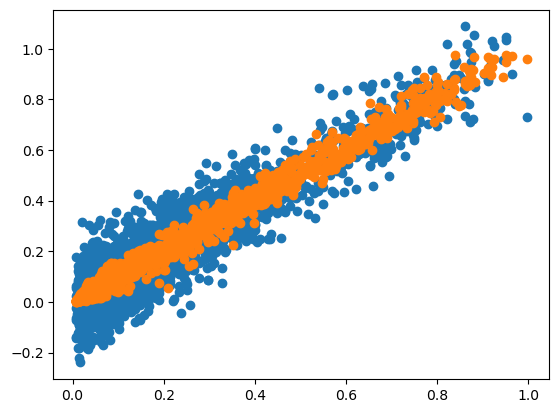

In [61]:
mycebmf.iter_once()  
mycebmf.update_fitted_value()
print(mycebmf.F)
plt.scatter(mycebmf.Y_fit, noisy_matrix)
 
plt.scatter(mycebmf.Y_fit, rank_1_matrix)

In [11]:
mycebmf.L2

tensor([[1.0000e-04, 7.7899e-04, 1.2892e-02, 4.8845e-02, 7.2173e-04],
        [1.0000e-04, 6.9659e-05, 1.0829e-02, 1.7804e-03, 4.0716e-03],
        [1.0000e-04, 4.8381e-02, 3.7041e-05, 2.8822e-03, 5.9370e-04],
        [1.0000e-04, 5.7427e-05, 4.5113e-02, 8.8694e-04, 4.0936e-02],
        [1.0000e-04, 2.7588e-02, 4.3183e-03, 3.0143e-02, 1.0568e-04],
        [1.0000e-04, 2.0004e-02, 1.4574e-04, 2.5273e-03, 1.4389e-03],
        [1.0000e-04, 4.3227e-05, 8.9942e-04, 3.2507e-03, 2.6995e-05],
        [1.0000e-04, 3.7442e-05, 1.9241e-02, 3.5441e-04, 9.1021e-04],
        [1.0000e-04, 4.3917e-03, 1.2020e-03, 4.4234e-02, 8.6074e-03],
        [1.0000e-04, 6.0569e-03, 1.0067e-03, 4.0017e-03, 2.9133e-04],
        [1.0000e-04, 2.1554e-03, 1.5021e-04, 1.2063e-04, 3.6063e-04],
        [1.0000e-04, 1.9450e-03, 1.5323e-02, 1.6926e-04, 7.3672e-02],
        [1.0000e-04, 6.7054e-04, 6.9780e-03, 1.9559e-02, 4.5495e-04],
        [1.0000e-04, 1.5777e-02, 2.7804e-04, 1.0355e-03, 1.1909e-04],
        [1.0000e-04,

In [12]:
mycebmf.update_fitted_value()

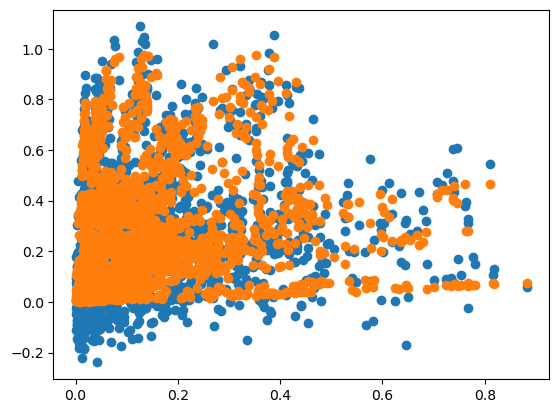

In [13]:
plt.scatter(mycebmf.Y_fit, noisy_matrix)
 
plt.scatter(mycebmf.Y_fit, rank_1_matrix)

In [14]:
from cebmf_torch.torch_main import *
mycebmf=  cEBMF(data= noisy_matrix,
                prior_L="point_exp",
                  prior_F="point_exp") 
mycebmf.initialize()
k=0

In [15]:
 

mycebmf.L

tensor([[-1.0800e+00,  8.0196e-03,  1.5701e-01,  2.6303e-01, -4.1739e-02],
        [-1.7109e-01, -1.9046e-01,  1.4650e-01,  3.7131e-02,  8.8875e-02],
        [-2.1563e+00,  2.6045e-01, -2.9440e-01,  5.0543e-02, -4.6051e-02],
        [-1.7606e+00, -2.1199e-01,  2.5109e-01, -1.1951e-02,  2.4847e-01],
        [-1.5449e+00,  2.1157e-01,  9.9516e-02,  2.0594e-01, -2.2076e-01],
        [-1.2314e+00,  1.8960e-01, -1.3784e-01,  5.0737e-02,  2.0818e-02],
        [-7.6256e-01, -2.4581e-01,  2.3146e-03,  7.5396e-02, -4.0319e-01],
        [-1.1439e+00, -2.6397e-01,  1.8187e-01, -8.0567e-02, -8.1205e-03],
        [-1.0905e+00,  1.0566e-01,  2.1918e-02,  2.5164e-01,  1.1956e-01],
        [-3.9036e+00,  1.2250e-01,  1.1006e-02,  8.3848e-02, -1.0205e-01],
        [-3.3608e+00,  6.7632e-02, -1.3782e-01, -1.8388e-01, -7.9343e-02],
        [-2.8256e-01,  6.1964e-02,  1.6782e-01, -1.5000e-01,  3.2100e-01],
        [-3.1371e+00, -1.5682e-03,  1.2186e-01,  1.8391e-01, -6.9569e-02],
        [-2.6537e+00,  1.

In [16]:

k=0
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2
mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)

In [17]:
se_l
resL.post_mean2

tensor([1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04])

In [18]:
from cebmf_torch.torch_ebnm_point_laplace import ebnm_point_laplace

lol=ebnm_point_laplace(
    x=lhat ,
    s=se_l ,    # a=exp(0)=1
    fix_par=[False,False, True] # optimize w only; fix a, mu
)

In [19]:
lol.post_sd

tensor([0.0792, 0.0632, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0787, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0788, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792], dtype=torch.float64)

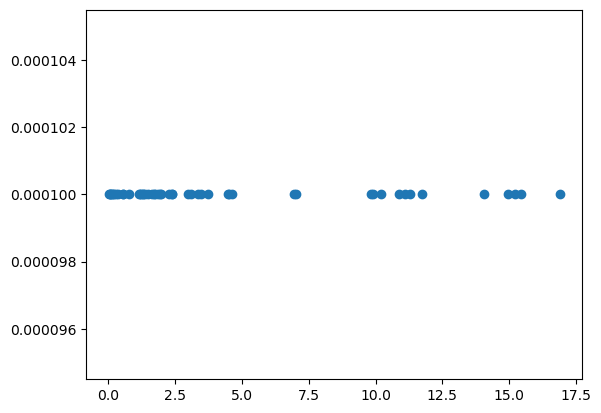

In [20]:
plt.scatter(lol.post_mean2,resL.post_mean2)

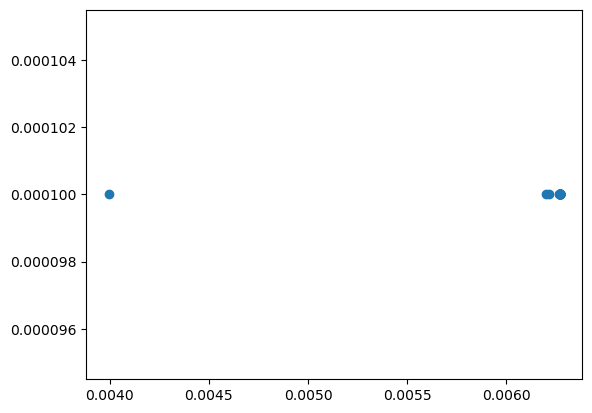

In [21]:
plt.scatter(lol.post_sd**2 ,resL.post_mean2-resL.post_mean**2)

In [22]:
mycebmf.prior_L_fn

<function cebmf_torch.priors_torch.prior_point_exp_torch(X, betahat: torch.Tensor, sebetahat: torch.Tensor, model_param=None) -> cebmf_torch.priors_torch.PriorResultTorch>

In [23]:
k=0
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
print(resL.post_mean)
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [24]:
denom_f = (lk2.view(-1, 1) * mycebmf.mask).sum(dim=0).clamp_min(eps)      # (P,)
num_f   = (Rk.T @ lk)                                                  # (P,)
se_f    = torch.sqrt(1.0 / (mycebmf.tau * denom_f))

In [25]:
mycebmf.mask

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [26]:
k=3
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
print(resL.post_mean)
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2
mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)
Rk = mycebmf._partial_residual_masked(k)            # recompute with updated L
lk  = mycebmf.L[:, k]                               # (N,)
lk2 = mycebmf.L2[:, k]                              # (N,)

if tau_map is None:
            denom_f = (lk2.view(-1, 1) * mycebmf.mask).sum(dim=0).clamp_min(eps)      # (P,)
            num_f   = (Rk.T @ lk)                                                  # (P,)
            se_f    = torch.sqrt(1.0 / (mycebmf.tau * denom_f))
else:
            denom_f = (tau_map * (lk2.view(-1, 1) * mycebmf.mask)).sum(dim=0).clamp_min(eps)  # (P,)
            num_f   = (tau_map * Rk).T @ lk                                                # (P,)
            se_f    = torch.sqrt(1.0 / denom_f)

fhat = num_f / denom_f 
resF = mycebmf.prior_F_fn(
            X=getattr(mycebmf, "X_f", None),
            betahat=fhat,
            sebetahat=se_f,
            model_param=mycebmf.model_state_F[k]
        )
mycebmf.model_state_F[k] = resF.model_param
print(resF.post_mean)
mycebmf.F[:, k]  = resF.post_mean
mycebmf.F2[:, k] = resF.post_mean2
mycebmf.kl_f[k]  = torch.as_tensor(resF.loss, device=mycebmf.device)


tensor([0.2005, 0.0181, 0.0212, 0.0106, 0.1333, 0.0212, 0.0287, 0.0056, 0.1875,
        0.0319, 0.0027, 0.0033, 0.1079, 0.0114, 0.0136, 0.0329, 0.0009, 0.0170,
        0.0014, 0.0142, 0.1156, 0.0095, 0.0067, 0.0127, 0.0152, 0.0077, 0.0030,
        0.1117, 0.0226, 0.0051, 0.0540, 0.2278, 0.0024, 0.0216, 0.0218, 0.0015,
        0.2305, 0.0124, 0.0031, 0.0646, 0.0084, 0.0216, 0.0228, 0.0027, 0.0038,
        0.0396, 0.0652, 0.1103, 0.0065, 0.0101], dtype=torch.float64)
tensor([0.6355, 1.4603, 0.1338, 1.7315, 1.0154, 0.0243, 2.2442, 1.4484, 1.4336,
        1.7043, 0.6233, 1.7560, 0.1497, 1.5003, 2.1372, 0.7855, 2.0447, 0.1461,
        1.8500, 1.0810, 1.1505, 1.9018, 1.7346, 0.5998, 0.8049, 0.2981, 0.8201,
        0.8180, 1.4623, 1.6915, 1.6831, 1.1200, 1.2191, 1.2364, 1.7742, 1.8638,
        1.7590, 1.8161, 1.7376, 1.0315], dtype=torch.float64)


In [27]:
se_f

tensor([0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281,
        0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281,
        0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281,
        0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281, 0.1281,
        0.1281, 0.1281, 0.1281, 0.1281])

In [28]:
from cebmf_torch.torch_ebnm_point_exp import ebnm_point_exp
lolf=ebnm_point_exp(
    x=fhat ,
    s=se_f ,    # a=exp(0)=1
    fix_par=[False,True, True] # optimize w only; fix a, mu
) 

In [29]:
lolf.post_mean

tensor([0.6038, 1.4286, 0.1231, 1.6999, 0.9837, 0.0303, 2.2125, 1.4167, 1.4019,
        1.6726, 0.5917, 1.7243, 0.1366, 1.4686, 2.1055, 0.7538, 2.0131, 0.1335,
        1.8183, 1.0494, 1.1188, 1.8701, 1.7029, 0.5681, 0.7732, 0.2698, 0.7885,
        0.7864, 1.4306, 1.6598, 1.6514, 1.0883, 1.1874, 1.2047, 1.7425, 1.8321,
        1.7273, 1.7844, 1.7059, 0.9998], dtype=torch.float64)

In [30]:
se_l


tensor([0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792])

In [31]:
lol.mu

0.0

In [32]:
lol.w

0.999930739402771

In [33]:
# make sure this is the stable version we discussed
from cebmf_torch.torch_ebnm_point_exp import ebnm_point_exp
res = ebnm_point_exp(
    x=lhat.float(),
    s=se_l.float() 
) 
res.post_mean  # shrunk toward 0, not all zero


tensor([0.2005, 0.0181, 0.0212, 0.0106, 0.1333, 0.0212, 0.0287, 0.0056, 0.1875,
        0.0319, 0.0027, 0.0033, 0.1079, 0.0114, 0.0136, 0.0329, 0.0009, 0.0170,
        0.0014, 0.0142, 0.1156, 0.0095, 0.0067, 0.0127, 0.0152, 0.0077, 0.0030,
        0.1117, 0.0226, 0.0051, 0.0540, 0.2278, 0.0024, 0.0216, 0.0218, 0.0015,
        0.2305, 0.0124, 0.0031, 0.0646, 0.0084, 0.0216, 0.0228, 0.0027, 0.0038,
        0.0396, 0.0652, 0.1103, 0.0065, 0.0101], dtype=torch.float64)

In [34]:
from cebmf_torch.torch_ash import ash
chk = ash(lhat.float(), se_l.float(), prior="norm")
chk.post_mean  # finite; should be close to lhat for large SNR


tensor([ 0.2188,  0.0062,  0.0091, -0.0019,  0.1427,  0.0091,  0.0160, -0.0178,
         0.2054,  0.0190, -0.1098, -0.0658,  0.1099, -0.0008,  0.0019,  0.0199,
        -0.3596,  0.0052, -0.2590,  0.0025,  0.1200, -0.0037, -0.0115,  0.0009,
         0.0035, -0.0077, -0.0866,  0.1149,  0.0104, -0.0229,  0.0422,  0.2452,
        -0.1418,  0.0094,  0.0096, -0.2456,  0.2476,  0.0006, -0.0784,  0.0546,
        -0.0060,  0.0095,  0.0105, -0.1081, -0.0464,  0.0266,  0.0554,  0.1130,
        -0.0124, -0.0027])

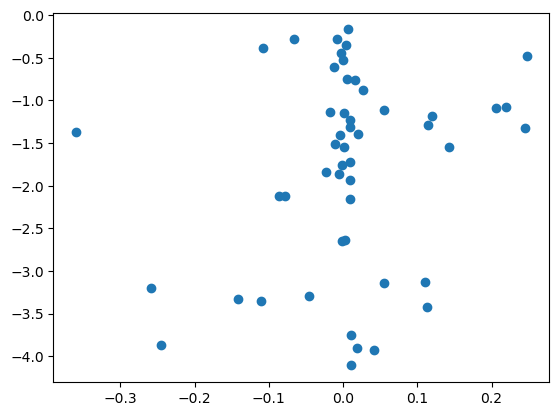

In [35]:
plt.scatter( chk.post_mean, lol.post_mean)



In [36]:

k=0
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2
mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)
se_l
resL.post_mean

tensor([6.7347e-01, 4.7844e-04, 1.0382e-06, 1.4445e-06, 2.4983e-05, 3.6217e-06,
        1.4250e-05, 3.3088e-06, 5.4869e-01, 3.0915e-07, 3.6415e-07, 4.8196e-05,
        8.4201e-07, 6.2016e-07, 3.7152e-06, 3.2613e-06, 2.1406e-06, 1.0278e-05,
        3.9973e-07, 6.4057e-07, 8.7082e-05, 2.2607e-06, 1.8791e-06, 1.9474e-06,
        5.8624e-05, 5.9860e-05, 9.1975e-07, 3.5085e-05, 3.2181e-07, 1.2513e-06,
        3.3894e-07, 6.7263e-01, 3.6963e-07, 1.3240e-06, 3.1425e-06, 2.7314e-07,
        1.5361e+00, 2.0124e-05, 9.1508e-07, 1.2357e-05, 1.2497e-06, 1.6914e-06,
        2.6546e-07, 2.6819e-05, 3.8062e-07, 1.3287e-05, 6.0968e-07, 6.6754e-07,
        1.2197e-05, 2.7202e-05], dtype=torch.float64)

In [37]:

k=2
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2
mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)
se_l
resL.post_mean

tensor([0.0744, 0.0706, 0.0012, 0.1936, 0.0355, 0.0031, 0.0109, 0.1084, 0.0128,
        0.0120, 0.0031, 0.0925, 0.0487, 0.0048, 0.0456, 0.0502, 0.0858, 0.0479,
        0.0032, 0.0466, 0.0012, 0.0018, 0.0018, 0.0204, 0.0065, 0.0038, 0.0379,
        0.0138, 0.2318, 0.0141, 0.0039, 0.2169, 0.0023, 0.0022, 0.0044, 0.2238,
        0.0014, 0.0052, 0.0048, 0.0033, 0.0126, 0.0059, 0.0187, 0.0019, 0.0023,
        0.1177, 0.0050, 0.0108, 0.0744, 0.2806], dtype=torch.float64)

In [38]:
lhat
se_l

tensor([0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792])

In [39]:
from cebmf_torch.torch_ebnm_point_laplace import ebnm_point_laplace
lol= ebnm_point_laplace(lhat , se_l) 
lol.post_mean


tensor([ 1.0082e-01,  9.7368e-02, -2.3768e-01,  1.9372e-01,  5.8615e-02,
        -9.1431e-02,  7.5782e-04,  1.2827e-01,  8.8796e-03,  5.6965e-03,
        -9.0896e-02,  1.1589e-01,  7.5473e-02, -4.9245e-02,  7.1872e-02,
         7.7194e-02,  1.1047e-01,  7.4512e-02, -8.5016e-02,  7.3029e-02,
        -2.4331e-01, -1.6580e-01, -1.6296e-01,  3.1340e-02, -2.8776e-02,
        -6.8683e-02,  6.1998e-02,  1.2681e-02,  2.2688e-01,  1.3709e-02,
        -6.7135e-02,  2.1359e-01, -1.2630e-01, -1.3285e-01, -5.6707e-02,
         2.1965e-01, -2.0917e-01, -4.3930e-02, -5.0060e-02, -8.4503e-02,
         7.8755e-03, -3.5405e-02,  2.7255e-02, -1.5521e-01, -1.2832e-01,
         1.3525e-01, -4.6712e-02,  1.3307e-04,  1.0083e-01,  2.7321e-01],
       dtype=torch.float64)

In [40]:
se_l

tensor([0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792])

In [41]:
lhat

tensor([ 1.5005e-01,  1.4587e-01, -2.9513e-01,  2.5072e-01,  9.4887e-02,
        -1.3858e-01,  1.3177e-03,  1.8167e-01,  1.5408e-02,  9.8965e-03,
        -1.3792e-01,  1.6771e-01,  1.1812e-01, -8.1157e-02,  1.1330e-01,
         1.2039e-01,  1.6145e-01,  1.1684e-01, -1.3051e-01,  1.1486e-01,
        -3.0079e-01, -2.2195e-01, -2.1899e-01,  5.3204e-02, -4.9024e-02,
        -1.0898e-01,  9.9695e-02,  2.1958e-02,  2.8428e-01,  2.3721e-02,
        -1.0685e-01,  2.7088e-01, -1.7949e-01, -1.8674e-01, -9.2141e-02,
         2.7699e-01, -2.6641e-01, -7.3095e-02, -8.2376e-02, -1.2986e-01,
         1.3671e-02, -5.9746e-02,  4.6525e-02, -2.1083e-01, -1.8173e-01,
         1.8937e-01, -7.7339e-02,  2.3139e-04,  1.5005e-01,  3.3075e-01])

In [42]:
lol= ebnm_point_laplace(lhat , se_l  ) 
lol.post_mean


tensor([ 1.0082e-01,  9.7368e-02, -2.3768e-01,  1.9372e-01,  5.8615e-02,
        -9.1431e-02,  7.5782e-04,  1.2827e-01,  8.8796e-03,  5.6965e-03,
        -9.0896e-02,  1.1589e-01,  7.5473e-02, -4.9245e-02,  7.1872e-02,
         7.7194e-02,  1.1047e-01,  7.4512e-02, -8.5016e-02,  7.3029e-02,
        -2.4331e-01, -1.6580e-01, -1.6296e-01,  3.1340e-02, -2.8776e-02,
        -6.8683e-02,  6.1998e-02,  1.2681e-02,  2.2688e-01,  1.3709e-02,
        -6.7135e-02,  2.1359e-01, -1.2630e-01, -1.3285e-01, -5.6707e-02,
         2.1965e-01, -2.0917e-01, -4.3930e-02, -5.0060e-02, -8.4503e-02,
         7.8755e-03, -3.5405e-02,  2.7255e-02, -1.5521e-01, -1.2832e-01,
         1.3525e-01, -4.6712e-02,  1.3307e-04,  1.0083e-01,  2.7321e-01],
       dtype=torch.float64)

In [43]:
lol.w

0.999811589717865

In [44]:
ebnm_point_laplace(
    x=lhat.double(),
    s=se_l.double(),    # a=exp(0)=1
    fix_par=[False,False, True] # optimize w only; fix a, mu
)

EBNMLaplaceResult(post_mean=tensor([ 1.0083e-01,  9.7379e-02, -2.3768e-01,  1.9373e-01,  5.8625e-02,
        -9.1442e-02,  7.5800e-04,  1.2828e-01,  8.8817e-03,  5.6979e-03,
        -9.0907e-02,  1.1590e-01,  7.5484e-02, -4.9254e-02,  7.1883e-02,
         7.7206e-02,  1.1048e-01,  7.4523e-02, -8.5027e-02,  7.3040e-02,
        -2.4331e-01, -1.6581e-01, -1.6297e-01,  3.1346e-02, -2.8782e-02,
        -6.8694e-02,  6.2008e-02,  1.2684e-02,  2.2689e-01,  1.3712e-02,
        -6.7146e-02,  2.1360e-01, -1.2631e-01, -1.3286e-01, -5.6717e-02,
         2.1965e-01, -2.0918e-01, -4.3939e-02, -5.0069e-02, -8.4514e-02,
         7.8774e-03, -3.5413e-02,  2.7261e-02, -1.5522e-01, -1.2833e-01,
         1.3526e-01, -4.6721e-02,  1.3311e-04,  1.0084e-01,  2.7321e-01],
       dtype=torch.float64), post_mean2=tensor([0.0154, 0.0146, 0.0624, 0.0437, 0.0078, 0.0069, 0.0036, 0.0221, 0.0037,
        0.0036, 0.0068, 0.0189, 0.0104, 0.0030, 0.0098, 0.0107, 0.0176, 0.0103,
        0.0056, 0.0100, 0.0652, 0.0311, 0

In [45]:
ebnm_point_laplace(
    x=lhat.double(),
    s=se_l.double(),
    par_init=[0.0, 2.0, 0.0],   # a=exp(0)=1
    fix_par=[False,False, True] # optimize w only; fix a, mu
)

EBNMLaplaceResult(post_mean=tensor([ 1.0083e-01,  9.7371e-02, -2.3768e-01,  1.9373e-01,  5.8618e-02,
        -9.1434e-02,  7.5786e-04,  1.2827e-01,  8.8801e-03,  5.6968e-03,
        -9.0899e-02,  1.1589e-01,  7.5476e-02, -4.9247e-02,  7.1875e-02,
         7.7198e-02,  1.1047e-01,  7.4515e-02, -8.5019e-02,  7.3032e-02,
        -2.4331e-01, -1.6580e-01, -1.6297e-01,  3.1341e-02, -2.8777e-02,
        -6.8686e-02,  6.2001e-02,  1.2682e-02,  2.2688e-01,  1.3710e-02,
        -6.7138e-02,  2.1359e-01, -1.2631e-01, -1.3285e-01, -5.6710e-02,
         2.1965e-01, -2.0917e-01, -4.3932e-02, -5.0062e-02, -8.4506e-02,
         7.8759e-03, -3.5407e-02,  2.7256e-02, -1.5522e-01, -1.2832e-01,
         1.3525e-01, -4.6714e-02,  1.3308e-04,  1.0083e-01,  2.7321e-01],
       dtype=torch.float64), post_mean2=tensor([0.0154, 0.0146, 0.0624, 0.0437, 0.0078, 0.0069, 0.0036, 0.0221, 0.0037,
        0.0036, 0.0068, 0.0189, 0.0104, 0.0030, 0.0098, 0.0107, 0.0176, 0.0103,
        0.0056, 0.0100, 0.0652, 0.0311, 0